### Installations

In [1]:
%pip install ffmpeg
%pip install scenedetect[opencv]
%pip install opencv-python --upgrade
%pip install -Uqq fastai
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [2]:
## Imports
# All-purpose Libraries
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import os, json
from urllib.request import urlopen
from random import sample

# For shot detection
from scenedetect import detect, ContentDetector, split_video_ffmpeg

# For frame extraction
import cv2

## Tutorial 5
from IPython.core.interactiveshell import InteractiveShell

from PIL import Image
# PyTorch
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets, models
from torchvision.transforms import v2

# Timing utility
from timeit import default_timer as timer

# Typing
from typing import Optional, Dict

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

## Constants
# Genres
GENRES = ['adventure', 'animation', 'biography', 'crime', 'musical',
          'mystery', 'sci-fi', 'sport', 'war', 'western']
ALL = 'all'
GENRE_NUM = 10
BUDGET_NUM = 3
COMBO_NUM = GENRE_NUM * BUDGET_NUM
DROP_P = 0.2
SEQ_NUM = 12

# Data Augementations
RESIZE_SIZE = 256
CENT_CROP_SIZE = 224
TRAIN = 'train'
VALID = 'valid'
TEST = 'test'

# Websites/URLs
IMDB_HOST = 'https://www.imdb.com'
VIDEO_DST = "/video/"
TRAILER_URL = IMDB_HOST + VIDEO_DST

# Directories
TITLE_DST = "/title/"
TRAILER_DIR = 'trailers/'
SHOT_DIR = "shots/"
FRAME_DIR = "frames/"
TRAIN_DIR = "training/"
VALID_DIR = "validation/"
VIDEO_DIR = 'videos/'
TEST_DIR = "test/"
COMBINED_DIR = "combined/"
MODELS_DIR = "models/"

# Trailer Base Directories
TRAILER_VIDEO_DIR = TRAILER_DIR + VIDEO_DIR
TRAILER_SHOT_DIR = TRAILER_DIR + SHOT_DIR
TRAILER_FRAME_DIR = TRAILER_DIR + FRAME_DIR

# Budget + Genre Frames
TRAILER_COMBO_DIR = TRAILER_FRAME_DIR + COMBINED_DIR
TRAIN_COMBO_DIR = TRAILER_COMBO_DIR + TRAIN_DIR
VALID_COMBO_DIR = TRAILER_COMBO_DIR+ VALID_DIR
TEST_COMBO_DIR = TRAILER_COMBO_DIR + TEST_DIR

# File Extensions
MP4_END = ".mp4"
JPG_END = ".jpg"

# Models
VGG16 = 'vgg16'
EFFINETV2 = 'effinetv2'

# Set Ratios
TRAIN_RATIO = 0.7

# Votes
K = 1000
M = 1000000
B = 1000000000

# Duration (mins)
HOUR = 60

# Budgets
LOW = "Low" # 0 to 40 mill - Paul Blart: Mall Cop 2 is 30-40 mill
LOW_END = 40000000
MED = "Medium" # 40 mill - 100 mill - https://gitnux.org/average-movie-budget/#:~:text=Highlights%3A%20The%20Most%20Important%20Average,US%20is%20about%20%2435%20million.
MED_END = 100000000
HIGH = "High" # 100 mill - 200 mill - Titanic is around 200 mill
TRAILER = 'trailer'

# Training-related Constants
CUDA = 'cuda'
BATCH_SIZE = 32 # Change to fit hardware
NUM_EPOCHS = 50
EARLY_STOP = 5

SAVE_FILE_EFFINETV2 = 'effinetv2-finetuned.pt'

# Image Transformations
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# Errors
BUDGET_NA = "Budget not found"
TRAILER_NA = "Trailer not found"
DIRECTOR_NA = "Director not found"
ACTOR_NA = "No actors found"
GENRES_NA = "Genres not found"
HTML_NA = "Invalid HTML content"
FRAME_NA = "Failed to write frame"
WEBPAGE_NA = 'Failed to get web page'
VIDEO_OPEN_NA = "Failed to open video file"
FRAME_COUNT_NA = "Failed to retrieve frame count"

# Metrics
TRAIN_LOSS = 'train_loss'
VALID_LOSS = 'valid_loss'

TRAIN_ACC = 'train_acc'
VALID_ACC = 'valid_acc'

# Others
SEP = '----------------------------------------------------------------'
RGB = 'RGB'
movies_collected = []

C:\Users\lanz_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

# Web Scraping Top Movies

## Cleanup

### Removes all files in specified path recursively

In [4]:
# import shutil
# shutil.rmtree(TRAILER_DIR)

### General Helpers

In [5]:
def create_dir(path: str) -> None:
    """
    Create a directory at <path> if one does not exist.
    """
    if (not os.path.exists(path)):
        os.mkdir(path)
        print(f"Created directory {path}")
        
def create_multi_dir(path: str) -> None:
    """
    Create the directories on the way to <path> if they do not exist.
    Afterwards, create a directory at <path>.
    """
    splits = path.split('/')
    acc = ""
    for dir in splits:
        acc += dir + "/"
        create_dir(acc)

def dir_exists(path: str) -> bool:
    """
    Return True if <path> is an existing directory.
    Return False otherwise.
    """
    return os.path.isdir(path)

def file_exists(path: str) -> bool:
    """
    Return True if <path> is an existing file.
    Return False otherwise.
    """
    return os.path.isfile(path)

In [6]:
#default is ==1 which means 50 entries
def get_genre_nth_page(genre: str, n=1) -> BeautifulSoup:
    """
    Return the HTML page of <n> * 50 movies with genre <genre> as a BeautifulSoup
    object for parsing.
    
    Prereq: n <= 5
    
    Args:
        genre (str): The genre of movies to collect
        n (int): How many movies to collect
        
    Returns:
        BeautifulSoup: The HTML page of <n> * 50 movies with genre <genre>.
    """
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1", "Accept-Language": "en-US, en;q=0.5"}
    start = 'https://www.imdb.com/search/title/?title_type=feature&genres='
    mid = '&count='
    num = str(n * 50)
    genre_url = start + genre + mid + num
    print(genre_url)
    response = requests.get(genre_url, headers=headers)

    if not response.ok:
        print('Status Code:', response.status_code)
        raise Exception(WEBPAGE_NA + genre_url)

    doc = BeautifulSoup(response.text)

    return doc

### Movie Name & URL

The movie name is enclosed within `a` tag which is inside a `h3` tag. We will first obtain the `h3` tag and then use it to extract the movie link and its text (movie name):

Create a Single Function to Fetch a Movie Page:

This function will retrieve and parse the HTML of a movie's IMDb page and return a BeautifulSoup object.

In [7]:
def fetch_movie_page(imdb_url: str) -> Optional[BeautifulSoup]:
    """
    Get the HTML response of <imdb_url>
    
    Args
        imdb_url (str): The URL to fetch the page of.
    
    Returns:
        Optional[BeautifulSoup]: The HTML page of the movie at <imdb_url>. Otherwise, None.
    """
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"}
    response = requests.get(imdb_url, headers=headers)
    if response.ok: return BeautifulSoup(response.text, 'html.parser')
    else: return None

### Budget

In [8]:

def find_budget(parsed_html: BeautifulSoup) -> str:
    """
    Return the estimated budget of a movie using its <parsed_html>.
    If the budget does not exist, return BUDGET_NA.
    Otherwise, return HTML_NA.
    """
    def cat_budget(budget_num: int) -> str:
        """
        Return the appropriate budget label for <budget_num>.
        Budget labels:
        - Low: <budget_num> < 40000000
        - Medium: 40000000 <= <budget_num> < 100000000
        - High: >= 100000000
        
        Args
            budget_num (int): The budget number to be categorized
            
        Returns
            str: <budget_num>'s label.
        """
        # Based on <budget_num>, return the corresponding range label for our CNN
        if (budget_num < LOW_END): return LOW
        if (budget_num < MED_END): return MED
        return HIGH

    if parsed_html:
        # Find whether the movie has an estimated budget on its IMDB page
        budget_tag = parsed_html.find('li', {'data-testid': 'title-boxoffice-budget'})
        
        # If the movie has an estimated budget
        if budget_tag:
            # Retrieve the movie's budget for our data
            budget = budget_tag.find('span', {'class': 'ipc-metadata-list-item__list-content-item'}).text.strip()
            import re
            budget = float(''.join(re.findall("\d+", budget)))
            return cat_budget(budget)

    # Otherwise, budget/page isn't available
        else: return BUDGET_NA
    else: return HTML_NA

### Trailers

In [9]:
def find_trailer(parsed_html: BeautifulSoup) -> str:
    """
    Finding trailer code adapted from
    https://github.com/pavan412kalyan/imdb-movie-scraper/blob/main/downloaders/trailer_downloader/getTrailerByImdb.py#L39-L45
    
    From our movie's json, check if our movie has a trailer. If it does, return the trailer's embedURL. Otherwise,
    return that the trailer has not found.
    
    Args
        parsed_html (BeautifulSoup): The HTML page of the movie
    """
    # Check if the movie has a trailer
    try: 
        jsonData = parsed_html.find('script',{"type":"application/ld+json"})
        jsonSourceObj=json.loads(jsonData.string)
        # Return the trailer's URL
        if TRAILER in jsonSourceObj:
            return jsonSourceObj['trailer']['embedUrl'].split('/')[-1]
    # Otherwise, no trailer to be found
        else: return TRAILER_NA
    except: return TRAILER_NA

def scrapeVidPage(parsed_html: BeautifulSoup) -> str:
    """
    scrapeVidPage function code adapted from
    https://github.com/pavan412kalyan/imdb-movie-scraper/blob/main/downloaders/trailer_downloader/getTrailerByImdb.py#L77-L92
    
    Find the trailer in <parsed_html> in its json. Once found, retrieve the video's playback URL from the json object.
    
    Args:
        parsed_html (BeautifulSoup): The HTML page of the movie
        
    Returns:
        str: The link to the first trailer of the movie.
    """
    script = parsed_html.find("script", {'type': 'application/json'})
    json_object = json.loads(script.string)
    videos = json_object["props"]["pageProps"]["videoPlaybackData"]["video"]["playbackURLs"]

    for video in videos[1:]:
        video_link = video["url"]
        break

    # Return the link to this trailer
    return video_link

def download(video_url: str, imdbID: str) -> None:
    """
    Download function code adapted from
    https://github.com/pavan412kalyan/imdb-movie-scraper/blob/main/downloaders/trailer_downloader/getTrailerByImdb.py#L48-L72
    
    Open the provided <video_url> and read its contents as an MP4 into the file "<TRAILER_DIR> + <imdbID> + <MP4_END>".
    Read the trailer in block sizes of 8192. If we cannot read anymore (ie. ru.read is None), then we have downloaded
    the entire trailer.
    
    Args:
        video_url (str): The video URL to download the video from
        imdbID (str): The movie's ID
    """
    ru = urlopen(video_url)

    # Create the trailer directory
    create_multi_dir(TRAILER_VIDEO_DIR)
    
    print(f"Downloading trailer for {imdbID}...")

    # Download the trailer
    f = open(TRAILER_VIDEO_DIR + imdbID + MP4_END, 'wb')
    file_size_dl = 0
    block_sz = 8192
    while True:
        buffer = ru.read(block_sz)
        if not buffer:
            break

        file_size_dl += len(buffer)
        f.write(buffer)
    f.close()

def split_to_shots(imdbID: str) -> None:
    """
    Split <imdbID>'s trailer into multiple shots, stored
    in the directory bearing the same <imdbID>.

    Args:
        imdbID (str): The movie's ID on IMDB
    """
    video = TRAILER_VIDEO_DIR + imdbID + MP4_END
    shot_movie_dir = TRAILER_SHOT_DIR + imdbID

    # Detect all shots in the video
    shot_lst = detect(video, ContentDetector())

    # Create appropriate directories
    create_multi_dir(shot_movie_dir) # Movie's shot directory

    # Split the trailer into shots, using ffmpeg
    split_video_ffmpeg(video, shot_lst, output_dir=shot_movie_dir)

def split_shots_to_rand_frames(imdbID: str, genre: str, budget: str) -> None:
    """
    Split a movie's trailer (with ID <imdbID>) shots into multiple frames,
    where each frame is one random location in a unique shot. Ensure these
    frames have the movie's ID, <genre>, and <budget> label for
    organizational purposes.
    
    Args:
        imdbID: (str): The movie ID of the movie trailer
        genre: (str): The genre of the movie
        budget: (str): The budget label of the movie
    """
    def write_frame(train_num: int, valid_num: int, test_num: int,
                    cap: cv2.VideoCapture, new_file: str):
        """
        Write a frame named <new_file> at any position in <cap>. Return
        <train_num>, <valid_num>, or <test_num> after we create a frame
        and decrement one of these counters.

        Args:
            train_num (int): Number of training frames left to write
            valid_num (int): Number of validation frames left to write
            test_num (int): Number of test frames left to write
            cap (cv2.VideoCapture): A shot
            new_file (str): The name of the new file to be written
        """

        def create_frame(loc: str, num: int) -> int:
            """
            Return the decremented <num> after creating a frame
            at <loc>. 

            Args:
                loc (str): The location where the frame should be written
                num (int): The number of frames left to write

            Returns:
                int: Return the decrement of <num> by 1, if the
                write operation of the frame is successful.
            """
            # If writing frame is successful, add it to the movie's list of frames
            if success:
                cv2.imwrite(loc, img)
                num -= 1
            else: print(FRAME_NA)
            return num
        
        # Get total # of frames
        if not cap.isOpened(): print(VIDEO_OPEN_NA)
        frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_num == 0: print(FRAME_COUNT_NA)
        
        # Get random frame
        rand_frame = np.random.randint(0, high=frame_num)
        cap.set(cv2.CAP_PROP_POS_FRAMES, rand_frame)
        success, img = cap.read()

        # Create the frame in the appropriate directory, based on our current
        # <train_num>, <valid_num>, and <test_num>.
        
        label = genre + "_" + budget
        file_label = "/" + label + "_" + new_file

        combo_label = label + file_label
        
        create_multi_dir(TRAIN_COMBO_DIR + label)
        create_multi_dir(VALID_COMBO_DIR + label)
        create_multi_dir(TEST_COMBO_DIR + label)

        if (train_num > 0): 
            train_num = create_frame(TRAIN_COMBO_DIR + combo_label, train_num)
        elif (valid_num > 0): 
            valid_num = create_frame(VALID_COMBO_DIR + combo_label, valid_num)
        elif (test_num > 0): 
            test_num = create_frame(TEST_COMBO_DIR + combo_label, test_num)
                
        return train_num, valid_num, test_num

    shot_movie_dir = TRAILER_SHOT_DIR + imdbID

    # Go through all shots
    shot_num = 0 # Total number of shots
    for filenme in os.listdir(shot_movie_dir):
        if (filenme.endswith(MP4_END)): shot_num += 1

    # Number of shots per set
    train_num = round(shot_num * TRAIN_RATIO)
    test_num = round((shot_num - train_num) // 2)
    valid_num = shot_num - train_num - test_num

    # Iterate over the movie's shots
    for filenme in os.listdir(shot_movie_dir):
        # Training, validation, and test frames will be of the form
        # <genre><budget>_<movie_id>.jpg
        new_file = filenme.removesuffix(MP4_END) + JPG_END

        # If the file's a shot
        if (filenme.endswith(MP4_END)):
            cap = cv2.VideoCapture(shot_movie_dir + "/" + filenme)

            # Write a random frame from the shot
            train_num, valid_num, test_num = write_frame(train_num, valid_num, test_num,
                                                         cap, new_file)


### Parse a movie

Download a movie's trailer and note its budget tag (based on its estimated budget).
If a movie's page doesn't have any of these elements, skip it.

In [10]:

def parse_movie(movie_tag: BeautifulSoup, genre: str) -> None:
    """
    Extract a movie's estimated budget and trailer from
    its IMDB page, located at <movie_tag>.
    
    Args
        movie_tag (BeautifulSoup): The movie's IMDB page
        genre (str): The genre of the movie we are parsing
    """
    # Split the name to remove the number
    href_full = movie_tag.find('a')['href']
    movie_id = href_full.split('?')[0]
    url = IMDB_HOST + movie_id
    
    # Process movie id
    movie_id = movie_id.removeprefix(TITLE_DST).strip('/')
    if movie_id in movies_collected:
        print("Movie already collected, skipping")
        return
    
    # Get movie page html
    movie_page_html = fetch_movie_page(url)

    # Process budget
    budget = find_budget(movie_page_html)

    # Process trailer
    trailer = find_trailer(movie_page_html)

    # For the sake of speeding up runtimes and to keep our training data consistent, 
    # we only consider movies with a valid budget and trailer.
    if trailer != TRAILER_NA and budget != BUDGET_NA:
        # Get the trailer page
        trailer_pg = fetch_movie_page(TRAILER_URL + trailer)
        
        # If the trailer page exists
        if (trailer_pg is not None):
            # Get the video URL of the trailer
            vid_url = scrapeVidPage(trailer_pg)

            # Download the trailer named after the movie's ID in the trailer directory
            # Don't download if it already exists
            if (not file_exists(TRAILER_VIDEO_DIR + movie_id + MP4_END)):
                download(vid_url, movie_id)
            else:
                print(f"Trailer for {movie_id} already exists, skipping download.")
            
            if (not dir_exists(TRAILER_SHOT_DIR + movie_id)):
                split_to_shots(movie_id) # Split the trailer into shots
            else:
                print(f"Shots for {movie_id} already made, skipping shot splitting.")

            # Split the shots into frames
            split_shots_to_rand_frames(movie_id, genre, budget)

        else: vid_url = TRAILER_NA
    else: vid_url = TRAILER_NA
    
    # Keep track of movies that we've already collected
    movies_collected.append(movie_id)

In [11]:
def get_top_movies(doc: BeautifulSoup, genre: str) -> None:
    """
    Parse all movies in <doc> with genre <genre>.

    Args
        doc (BeautifulSoup): The HTML page for movies of genre <genre>.
        genre (str): The genre of movies we are collecting.
    """
    # Obtain a list of movie tags from the html source code
    movie_tags = doc.find_all('li', class_ = 'ipc-metadata-list-summary-item')

    for movie_num, tag in enumerate(movie_tags):
        print(f"Processing movie {movie_num}")
        parse_movie(tag, genre)
        print(SEP)

In [12]:
def get_n_pages(genre: str, n: int) -> None:
    """
    Prereq: 0 < n <= 5
    
    Get <n> * 50 of IMDB's top movies with genre <genre>.
    
    Args
        genre (str): The genre of movies to collect
        n (int): How many movies we should consider in our data
        collection process multiplied by 50.
    """
    if genre == ALL:
        for genre in GENRES:
            get_top_movies(get_genre_nth_page(genre, n), genre)
    else:
        get_top_movies(get_genre_nth_page(genre, n), genre)

## Extracting top movies from all genres in our genre list

In [13]:
# get_n_pages(ALL, 1) # Takes > 4 hrs for n == 5

# Movie Genre and Budget Predictions

## Setup

In [14]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1: multi_gpu = True

Train on gpu: True
1 gpus detected.


### Generic ML Training Functions

#### Counting Functions

In [15]:
def count_frames() -> None:
    """
    Count the number of frames in our training, validation, and test directories.
    """
    print(f"Training extracted frames num: {(count_files(TRAIN_COMBO_DIR, JPG_END))}")
    print(f"Validation extracted frames num: {count_files(VALID_COMBO_DIR, JPG_END)}")
    print(f"Test extracted frames num: {count_files(TEST_COMBO_DIR, JPG_END)}")

def count_files(dir: str, ending: str) -> int:
    """
    Return the number of files ending with <ending> in <dir> recursively.
    
    Args:
        dir (str): The directory to search for files in.
        ending (str): The file extension that counted files must end in.
        
    Returns:
        int: The count of files in <dir> that end in <ending>.
    """
    return len([file for _, _, files in os.walk(dir) 
                     for file in files if file.endswith(ending)])

#### Dataset Preparation for Training

In [16]:
def equalize_datasets() -> None:
    """
    Ensure all of our training, validation, and test datasets' class frames
    are all divisible by SEQ_NUM.
    """
    def equalize_dir(path: str) -> None:
        """
        Ensure all directories at <path> are divisible by SEQ_NUM.
        
        Args
            path (str): The path to check all frames
        """
        for class_label in os.listdir(path):
            label = "/" + class_label
            size = count_files(path + label, JPG_END) # Class files
            to_remove = size % SEQ_NUM

            # Remove random frames
            for file in sample(os.listdir(path + label), to_remove):
                os.remove(path + label + "/" + file)
                
        print(f"Equalized {path} - All directories are divisible by {SEQ_NUM} frames.")
        print(SEP)
            
    equalize_dir(TRAIN_COMBO_DIR)
    equalize_dir(VALID_COMBO_DIR)
    equalize_dir(TEST_COMBO_DIR)
    
def class_weights() -> torch.Tensor:
    """
    Return the weight for every class in our custom model as a tensor with
    dimension (C, ), where C is the number of our classes.
    
    A class weight is determined by the class with the highest frame count
    in our training, validation, and test directory frames divided by the
    a class's frame count in these directories.
    
    Returns:
        torch.Tensor: The weights for each class as a tensor with dimensions
        (C, ), where C is the number of our classes.
    """
    max_frames = float('-inf')
    sizes = []
    for class_label in os.listdir(TRAIN_COMBO_DIR):
        label_dir = "/" + class_label
        size = (count_files(TRAIN_COMBO_DIR + label_dir, JPG_END) + 
                count_files(VALID_COMBO_DIR + label_dir, JPG_END) + 
                count_files(TEST_COMBO_DIR + label_dir, JPG_END))
        max_frames = max(max_frames, size)
        sizes.append(size)
    return torch.Tensor([max_frames / sizes[i] for i in range(COMBO_NUM)])

In [34]:
count_frames()       # Original Frame Counts
print(SEP)
equalize_datasets()  # Ensure datasets are divisible by SEQ_NUM

Training extracted frames num: 80077
Validation extracted frames num: 17596
Test extracted frames num: 16713
----------------------------------------------------------------
Equalized trailers/frames/combined/training/ - All directories are divisible by 12 frames.
----------------------------------------------------------------
Equalized trailers/frames/combined/validation/ - All directories are divisible by 12 frames.
----------------------------------------------------------------
Equalized trailers/frames/combined/test/ - All directories are divisible by 12 frames.
----------------------------------------------------------------


#### Train Function (adapted from Tutorial 6)

In [18]:
def get_acc_log(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Compute accuracy by comparing the maximum element in <output> to <target>.
    
    Args:
        output (torch.Tensor): The outputted probabilites of our model.
        target (torch.Tensor): The ground truth of our set of frames.
        
    Returns:
        torch.Tensor: The average result of our model's predictions, when compared
        to our ground truth.
    """
	# Calculate accuracy by finding max log probability
    _, pred = torch.max(output, dim=1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    # Need to convert correct tensor from int to float to average
    return torch.mean(correct_tensor.type(torch.FloatTensor))

In [19]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """
    Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_best_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    print(f"Batch Size: {BATCH_SIZE}")
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss, valid_loss = 0.0, 0.0
        train_acc, valid_acc = 0, 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
                
            # Clear gradients
            optimizer.zero_grad()

            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            accuracy = get_acc_log(output, target)
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1
            train_load_size = len(train_loader.dataset)
            valid_load_size = len(valid_loader.dataset)

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    accuracy = get_acc_log(output, target)

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / train_load_size
                valid_loss = valid_loss / valid_load_size

                # Calculate average accuracy
                train_acc = train_acc / train_load_size
                valid_acc = valid_acc / valid_load_size

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[TRAIN_LOSS, VALID_LOSS, TRAIN_ACC, VALID_ACC])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=[TRAIN_LOSS, VALID_LOSS, TRAIN_ACC, VALID_ACC])
    return model, history

In [20]:
def begin_training(model: nn.Module, datloads: Dict[str, DataLoader], save_file_name: str):
    """
    Set up <model> for training, using NLLLoss and an Adam optimizer. 
    The model will use <datloads> as its training data and
    will save its state in the file <save_file_name>.
    
    Args:
        model (nn.Module): Our custom model.
        datloads (Dict[str, Dataloader]): Where our data loaders for our training, validation,
        and test sets are stored.
        save_file_name (str): Where to save the state of our model after each epoch.
        
    Returns
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    # Set criterion and optimizer
    weights = class_weights()
    print(f"Class weights: {weights}")

    # Put on the GPU if available
    if train_on_gpu:
        print("Training on GPU")
        weights = weights.to(CUDA)
        model = model.to(CUDA)

    criterion = nn.NLLLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    return train(model, criterion, optimizer, datloads[TRAIN], datloads[VALID],
                 save_file_name=save_file_name, max_epochs_stop=EARLY_STOP, n_epochs=NUM_EPOCHS,
                 print_every=1)

#### Model Metrics

In [21]:
def show_metrics(hist: pd.DataFrame, loss_title="Training and Validation Losses",
                 acc_title="Training and Validation Accuracy") -> None:
    """
    Display the loss and accuracy of our model during training and validation, given
    the model's <hist>. Display these plots with the titles <loss_title> and <acc_title>
    respectively.
    """
    # Loss plot
    plt.figure(figsize=(8, 6))
    for c in [TRAIN_LOSS, VALID_LOSS]:
        plt.plot(hist[c], label=c)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Average Negative Log Likelihood')
    plt.title(f"{loss_title}")

    # Accuracy plot
    plt.figure(figsize=(8, 6))
    for c in [TRAIN_ACC, VALID_ACC]:
        plt.plot(100 * hist[c], label=c)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Average Accuracy')
    plt.title(f'{acc_title}')

### Dataset Preparation

#### Dataset Augmentation/Transformations

In [22]:
# Image transformations
IMAGE_TRANSFORMS = {
    # Train uses data augmentation
    TRAIN:
    v2.Compose([
        v2.RandomResizedCrop(size=RESIZE_SIZE),
        v2.CenterCrop(size=CENT_CROP_SIZE),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=NORM_MEAN, std=NORM_STD)  # Imagenet standards
    ]),
    VALID:
    v2.Compose([
        v2.Resize(size=RESIZE_SIZE),
        v2.CenterCrop(size=CENT_CROP_SIZE),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=NORM_MEAN, std=NORM_STD)
    ]),
    TEST:
    v2.Compose([
        v2.Resize(size=RESIZE_SIZE),
        v2.CenterCrop(size=CENT_CROP_SIZE),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=NORM_MEAN, std=NORM_STD)
    ]),
}

#### Image Sequence Class

In [23]:
class ImageSeqDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, sequence_length=SEQ_NUM):
        self.transform = transform
        self.sequence_length = sequence_length
        self.image_folder = datasets.ImageFolder(root=root)

    def __len__(self) -> int:
        return len(self.image_folder) - self.sequence_length + 1

    def __getitem__(self, idx: int):
        images = []
        for i in range(idx, idx + self.sequence_length):
            # If we can make an image sequence of len SEQ_NUM
            if (i < len(self.image_folder.imgs)):
                image_path = self.image_folder.imgs[i][0]
                image = Image.open(image_path).convert(RGB)

                # Apply transformations to the given image
                if self.transform: image = self.transform(image)
                images.append(image) # Add to our image sequence
            else: # If not enough for a sequence
                break

        sequence = torch.stack(images)
        label = self.image_folder[idx][1] # All images in seq belong to the same label
        return sequence, label

In [24]:
def collate_fn_rnn(batch):
    """
    Taken from https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031.
    
    Return the sequences of images and their corresponding ground truths as tensors, given
    our <batch>.
    """
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor, labels_tensor

#### Get Datasets and Loaders

In [25]:
def get_data_and_loaders(train_dir: str, valid_dir: str, test_dir: str):
    """
    Load our training, validation, and test frames from <train_dir>, <valid_dir>, and <test_dir>.
    
    Args:
        train_dir (str): Where our training frames are located.
        valid_dir (str): Where our validation frames are located.
        test_dir (str): Where our test frames are located.
    """
    # Datasets from each folder
    dat = {
        TRAIN: ImageSeqDataset(root=train_dir, transform=IMAGE_TRANSFORMS[TRAIN]),
        VALID: ImageSeqDataset(root=valid_dir, transform=IMAGE_TRANSFORMS[VALID]),
        TEST: ImageSeqDataset(root=test_dir, transform=IMAGE_TRANSFORMS[TEST])
    }
    # Dataloader iterators
    dat_loaders = {
        TRAIN: DataLoader(dat[TRAIN], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_rnn),
        VALID: DataLoader(dat[VALID], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_rnn),
        TEST: DataLoader(dat[TEST], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_rnn)
    }
    return dat, dat_loaders

#### Lower Amount of Data Collected

In [26]:
def trim_dirs(k: int) -> None:
    """
    Ensure our training, validation, and test datasets have less than or equal to the number of frames
    as the <k>th smallest directory.
        
        Args
            k (int): The kth shortest directory whose number of frames is what
            all subdirectories should have (equal to or less than)  
    """
    def trim_dir(path: str, k: int) -> None:
        """
        Ensure all directories at <path> have less than or equal to the number of frames
        as the <k>th smallest directory.
        
        Args
            path (str): The path where all frames should be reduced
            k (int): The kth shortest directory whose number of frames is what
            all subdirectories should have (equal to or less than)  
        """
        sizes = []
        for class_label in os.listdir(path):
            size = len([file for file in os.listdir(path + "/" + class_label) 
                        if file_exists(path + "/" + class_label + "/" + file)])
            sizes.append(size)
        
        if (k > len(sizes)): k = len(sizes) - 1
        min_frames = sorted(sizes)[k]
        print(f"{k}-th smallest in {path} (0-indexed): {min_frames}")
        
        print("Trimming...")
        from random import sample
        for i, class_label in enumerate(os.listdir(path)):
            num_remove = sizes[i] - min_frames
            if (num_remove > 0):
                for file in sample(os.listdir(path + "/" + class_label), num_remove):
                    os.remove(path + "/" + class_label + "/" + file)
                
        print(f"Trimmed {path} - Directories now have {min_frames} frames or lower")
        print(SEP)
            
    trim_dir(TRAIN_COMBO_DIR, k)
    trim_dir(VALID_COMBO_DIR, k)
    trim_dir(TEST_COMBO_DIR, k)

In [27]:
trim_dirs(0) # 0-indexed

## Combination Model

### Data Preparation: Combination

#### View sizes of training, validation, and test folders

In [28]:
# Final Frame counts
count_frames()

Training extracted frames num: 12600
Validation extracted frames num: 2520
Test extracted frames num: 2520


#### Dataloaders

In [29]:
# Datasets from each folder
data, dataloaders = get_data_and_loaders(TRAIN_COMBO_DIR, VALID_COMBO_DIR, TEST_COMBO_DIR)

### Custom Model Definition

In [30]:
class effnetv2RNN(nn.Module):
    """
    Basic process:
        1. Process the input image into a pretrained CNN (EfficientNetv2, in this case)
        2. Use the processed output (not processed into prediction yet) as input to our RNN
        3. Repeat steps 1-2 for the rest of our image sequence until we are at the end of the image sequence
            - This is so the RNN can learn from our past images
        4. After passing the last image to our RNN, process its output into a prediction
        using our layers.
        
    Adapted from: https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031,
    which uses ResNet18 and an RNN as its model architecture.
    """
    def __init__(self, rnn_num_layers: int, rnn_hidden_size: int) -> None:
        super(effnetv2RNN, self).__init__()
        last_layer = 1
        
        ## Setup CNN
        cnn = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        num_features = cnn.classifier[last_layer].in_features
        
        # Replace last layer of efficientnet_v2 w/ identity layer
        cnn.classifier[last_layer] = nn.Identity()
        
        # Freeze early layers of CNN
        for param in cnn.parameters():
            param.requires_grad = False

        self.cnn = cnn
        
        # Last layers for classification
        self.dropout = nn.Dropout(DROP_P)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(rnn_hidden_size, COMBO_NUM)
        self.logmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        # x = (batch_size, sequence_length, channels, height, width)
        _, ts, _, _, _ = x.shape
        ii = 0
        
        # Get prediction for the first image in our sequence
        y = self.cnn((x[:,ii]))
        
        # 2D => 3D tensor and pass it in our RNN
        # (hn, cn) => (hidden state, cell state)
        _, (hn, cn) = self.rnn(y.unsqueeze(1))
        
        # Pass the rest of our images into our RNN, 
        # leveraging RNN's memory 
        for ii in range(1, ts):
            y = self.cnn((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))

        out = self.relu(out[:, -1]) # ReLU layer
        out = self.dropout(out)     # Dropout layer
        out = self.fc1(out)         # hidden_size => 30 classes
        out = self.logmax(out)      # Turn to probabilities
        return out

In [31]:
def get_model(save_file_name="") -> nn.Module:
    """
    Return the custom model "effnetv2RNN". If the model has an existing save file
    with the name <save_file_name>, load this model's state from that file.
    
    Args"
        save_file_name (str): Where to load our model's state (if available)
        
    Returns:
        nn.Module: Our custom model
    """
    # Get our custom model
    model = effnetv2RNN(1, 256)
    if (file_exists(save_file_name)):
        model.load_state_dict(torch.load(save_file_name))
    return model

#### Train our model from scratch (Combination labels => 30 classes)

In [32]:
# Get our custom model
model = get_model(SAVE_FILE_EFFINETV2)

# Begin training 
model, history = begin_training(model, dataloaders, SAVE_FILE_EFFINETV2)

In [589]:
# Save history to file
history.to_csv("model_stats.csv")

#### Training Plots

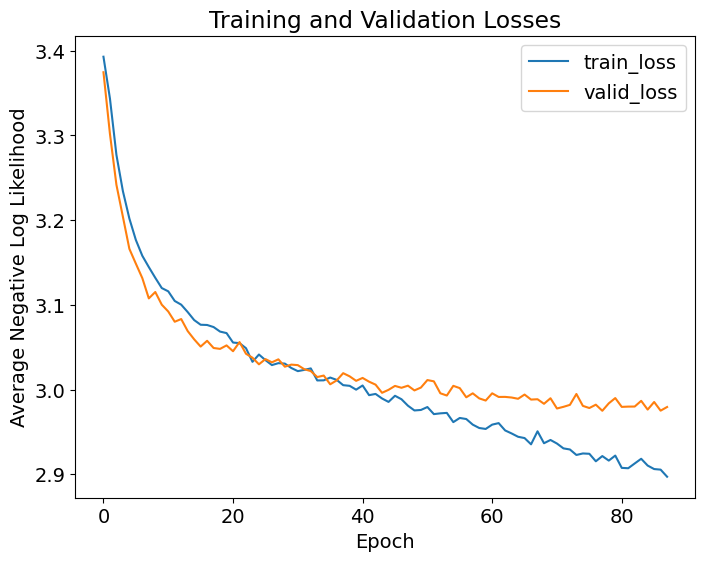

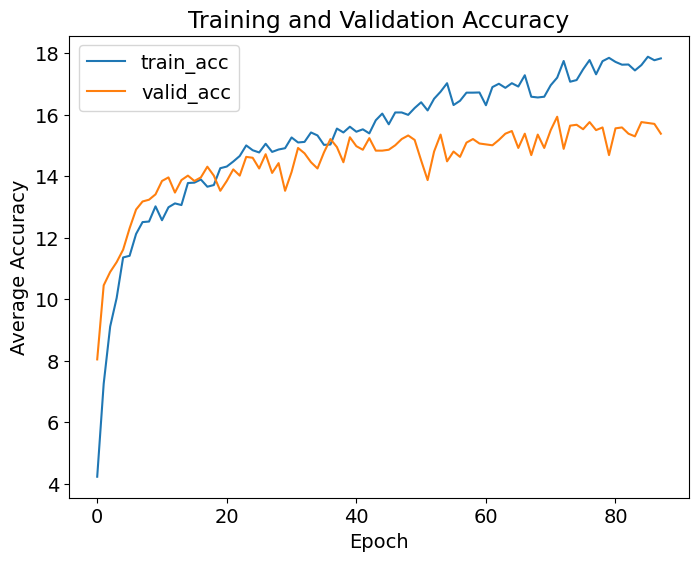

In [590]:
show_metrics(history, loss_title="Training and Validation Losses",
             acc_title="Training and Validation Accuracy")

#### Evaluation (Test Data)

In [33]:
def eval_test(model: nn.Module, test_loader: DataLoader):
    """
    Evaluate <model> by loading the test set from <test_loader> and returning
    <model>'s test loss and accuracy.
    
    Args:
        model (nn.Module): Our custom model.
        test_loader (DataLoader): The loader for our test data.
    """
    weights = class_weights()
    print(f"Class weights: {weights}")
    if train_on_gpu:
        print("Testing on GPU")
        weights = weights.to(CUDA)
        model = model.to(CUDA)
    criterion = nn.NLLLoss(weight=weights)

    start = timer()
    # keep track of test loss and accuracy
    test_loss, test_acc = 0.0, 0

    # Test loop
    with torch.no_grad():
        model.eval()
        
        for ii, (data, target) in enumerate(test_loader):
            # Tensors to gpu
            if train_on_gpu: 
                data, target = data.cuda(), target.cuda()
                
			# Forward pass
            output = model(data)
                
            # Test loss
            loss = criterion(output, target)

            # Track train loss by multiplying average loss by number of examples in batch
            test_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            accuracy = get_acc_log(output, target)
            test_acc += accuracy.item() * data.size(0)

            print(
            f'{100 * (ii + 1) / len(test_loader):.2f}% complete. {timer() - start:.2f} elapsed.',
            end='\r')

    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)
            
    print(f'Test Loss: {test_loss:.2f}\t Test Accuracy: {100 * test_acc:.2f}%')
    print(f'{timer() - start:.2f} total seconds elapsed.')

    return test_loss, test_acc

eval_test(model, dataloaders[TEST])

Class weights: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Testing on GPU
Test Loss: 3.07	 Test Accuracy: 13.43%
276.28 total seconds elapsed.


(3.068778090193814, 0.13431646080072204)

# Other Functions

### Functions that collect more information about a movie (mentioned in potential future work)

#### Year of Release

We can obtain the release year using the tag: `span` and class: `lister-item-year text-muted unbold`. The release date is not given on the website for a few movies since they are still in production. So we write a function to take the value as `None` where no release date is available:

In [ ]:
def find_year(movie_soup: BeautifulSoup) -> Optional[int]:
    """
    Return the year of the movie at <movie_tag>.
    
    Args:
        movie_tag (BeautifulSoup): The movie's IMDB page.
    
    Returns:
        Optional[float]: The movie's year of release. None if the movie's
        release date is unavailable.
    """
    try:
        year = movie_soup.find('span', class_='dli-title-metadata-item').text[-5:]
        return int(year)
    except (AttributeError, ValueError):
        return None

#### Duration

In [ ]:
def find_duration(movie_tag: BeautifulSoup) -> Optional[float]:
    """
    Return the duration of the movie at <movie_tag>.
    
    Args:
        movie_tag (BeautifulSoup): The movie's IMDB page.
    
    Returns:
        Optional[float]: The movie's duration. None if the movie's
        duration is unavailable.
    """
    def dur_to_num(x: str) -> float:
        """
        Return the float version of <x>.
        
        Args:
            x (str): The string to convert to a float.
        
        Returns:
            float: The float version of <x>.
        """
        # If no duration is available, return -1
        
        if x is None: 
            return -1
        
        # Remove the minute tag of duration, then split the duration into parts
        x = x.strip('m').split(' ')

        # If exactly "X hrs" or "Y mins"
        if len(x) == 1: 
            # If "X hrs"
            if (len(x[0].strip('h')) != len(x[0])):
                return float(x[0].strip('h')) * HOUR
            try:
                # If "Y mins"
                return float(x[0]) # (already stripped 'm')
            except:
                # Something like Motion Picture Rating (MPA): "G"
                return -1 # -1 to indicate that no duration has been found
        return float(x[0].strip('h')) * HOUR + float(x[1]) # Eg. 1 hr 30 mins
    
    try:
        # Find all spans with the class 'dli-title-metadata-item'
        metadata_items = movie_tag.find_all('span', class_ = 'dli-title-metadata-item')

        # The duration is expected to be the second item, if it exists.
        if len(metadata_items) > 1:
            duration = metadata_items[1].text.strip()
        else: # Still in production - No duration available
            duration = None
    except AttributeError:
        duration = None

    # Return the duration, corresponding to our budget ranges
    return dur_to_num(duration)

#### IMDB Rating

We can obtain the IMDB rating using the tag: `div` and class: `inline-block ratings-imdb-rating`. The rating is not given on the website for a few movies since they are still in production. So we write a function to take the value as `None` where no rating is available:

In [ ]:
def find_imdb_rating(movie_tag: BeautifulSoup) -> Optional[float]:
    """
    Find the IMDB rating of the movie at <movie_tag>.
    
    Args:
        movie_tag (BeautifulSoup): The HTML page of the movie.
        
    Returns:
        Optional[float]: The rating of the movie. None if the rating is unavailable.
    """
    try:
        # Using CSS selector to find the span with a part of the class name
        rating_span = movie_tag.select_one('span.ipc-rating-star--imdb')

        # Extracting the text, splitting by space and taking the first part
        if rating_span:
            imdb_rating_text = rating_span.text.strip()
            imdb_rating = imdb_rating_text.split()[0]  # Split the string and take the first part
            imdb_rating = float(imdb_rating)  # Convert to float
        else: # Still in production - No duration available
            imdb_rating = None 
    except (AttributeError, ValueError): imdb_rating = None

    return imdb_rating

#### Number of Votes

In [ ]:
def find_votes(movie_tag: BeautifulSoup) -> Optional[float]:
    def votes_to_num(x: str) -> int:
        """
        Interpret the extracted string <x> as an integer.

        Args:
            x (str): The extracted "Votes" string

        Returns:
            int: The integer interpretation of <x>.
        """
        # If there are no votes, return None
        if x is None: 
            return x
        
        # K = 1,000
        if 'K' in x:
            if len(x) > 1: return float(x.replace('K', '')) * K
            return K
        # M = 1,000,000
        if 'M' in x:
            if len(x) > 1: return float(x.replace('M', '')) * M
            return M
        # B = 1,000,000,000
        if 'B' in x: 
            return float(x.replace('B', '')) * B
        # Otherwise, return 0
        return 0
    try:
        # Using CSS selector to find the span with a part of the class name
        rating_span = movie_tag.select_one('span.ipc-rating-star--imdb')

        # Extracting the text, splitting by space and taking the first part
        if rating_span:
            imdb_rating_text = rating_span.text.strip()
            imdb_rating = imdb_rating_text.split()[1]  # Split the string and take the second part
            imdb_rating = imdb_rating[1:-1]  # Remove the parentheses
        else: # Still in production - No duration available  
            imdb_rating = None
    except (AttributeError, ValueError): imdb_rating = None

    return votes_to_num(imdb_rating)